# Topic Modeling with Latent Dirichlet Allocation (LDA)

## Import all important packages

In [1]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# The next imports are only needed for the preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from utils.nlputil import preprocess_text

## Defintion of toy dataset

For this simple example, we define our corpus as a list of documents. Each documents is only a single sentence to keep the example easy to follow. Naturally, a document may contain a large number of sentences.

In [2]:
documents = ["cats and dogs are both domesticated animals.",
             "the domestication of dogs started 10,000 years ago.",
             "dogs were easier to domensticate than cats.",
             "Some people have a dog and a cat (or several dogs and cat) as pets.",
             "the domestication of animals was an important part of human progress.",
             "python is a programming laguage that is easy to learn",
             "python makes text processing rather easy.",
             "a lot of programming languages support text analysis.",
             "programming in python makes the analysis of text easy",
             "nltk is a great nlp package for python."]

## Prepocessing

Preprocessing is not required by LDA, but is often intuitive to, for example, consider the singular and plural forms of nouns as the same term.

In [3]:
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

The `preprocess_text()` method sllows for all kinds of parameters to affect the preprocessing; see the file `nlputil.py` for more details. You can try different parameters and see the how the documents but also the results of LDA change.

In [4]:
# Define a list of length len(documents) initialized with empty strings
# (we don't want to override the original documents here)
processed_documents = [''] * len(documents)

for idx, doc in enumerate(documents):
    #processed_documents[idx] = preprocess_text(doc)
    #processed_documents[idx] = preprocess_text(doc, stemmer=porter_stemmer)
    processed_documents[idx] = preprocess_text(doc, lemmatizer=wordnet_lemmatizer)

# Print the processed documents
for doc in processed_documents:
    print (doc)

cat dog domesticated animal
domestication dog start 10000 year ago
dog easy domensticate cat
people dog cat several dog cat pet
domestication animal important part human progress
python programming laguage easy learn
python make text process rather easy
lot program language support text analysis
program python make analysis text easy
nltk great nlp package python


## Generate document term matrix

In [5]:
num_words = 1000 # Top 1000 words

The `CountVectorizer` is, among other vectorizers, a handy and flexible way to generate a document term matrix. Mores specificall, here each value in the matrix represents the count how of a term $t_i$ occurs in document $d_j$.

The `CountVectorizer` class allows for a wide range of useful input parameters to configurate the generation of the document term matrix; In this example, we use the following:

- `max_df`: If not `None` one can specify how often a word has to be in the corpus AT MOST, either in relative terms or in absilute terms. This allows to ingnore words that a very COMMON across all documents and that are not very discriminative.
- `min_df`: If not `None` one can specify how often a word has to be in the corpus AT LEAST, either in relative terms or in absilute terms. This allows to ingnore rare words that a very RARE across all documents and that are not very discriminative.
- `max_features`: If not `None` one can limit the number of words to ones with the highest counts (term frequencies) acroess the whole corpus
- `stop_words`: If not `None` one can specify the list of stop words to be removed from each document (not really necessary if stop words are removed during preprocessing)

The `CountVectorizer` accepts more optional input parameters, see here:
- http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [6]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_words, stop_words='english')

In [7]:

tf = tf_vectorizer.fit_transform(processed_documents)
vocabulary = tf_vectorizer.get_feature_names()



### Visualize document term matrix

Just for illustrative purposes, let's print the document term matrix. This is only meaningful for the toy datasets, but highlights the the effects of the different preprocessing options evne before performing LDA.

In [8]:
from pandas import DataFrame

print(DataFrame(tf.A, columns=vocabulary).to_string())

   analysis  animal  cat  dog  domestication  easy  make  program  python  text
0         0       1    1    1              0     0     0        0       0     0
1         0       0    0    1              1     0     0        0       0     0
2         0       0    1    1              0     1     0        0       0     0
3         0       0    2    2              0     0     0        0       0     0
4         0       1    0    0              1     0     0        0       0     0
5         0       0    0    0              0     1     0        0       1     0
6         0       0    0    0              0     1     1        0       1     1
7         1       0    0    0              0     0     0        1       0     1
8         1       0    0    0              0     1     1        1       1     1
9         0       0    0    0              0     0     0        0       1     0


## Perform LDA

First, we need to set the number of topics. In practice, this is not know a-priori. For our toy example, we know to expect 2 topics. You can still change the value and then interpret compare the different results.

In [9]:
num_topics = 2

In [10]:
lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=100, learning_method='online', learning_offset=50.,random_state=0)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_jobs=1, n_topics=2, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

The result of the model are not probabilites, i.e., the values do to sum up to 1. In most cases, this is not a problem since the absolute values but the relative differences are the important parts. In other words, most of the time these values do not matter at all.

However, for illustrative purposes, we can normalize all values to proper probabilities

In [11]:
lda.components_ /= lda.components_.sum(axis=1)[:, np.newaxis]

## Evaluating the results

### Show distribution of words for topics

`display_topics()` is just a utility method to display the results. For each topic, it ranks all word with respect to the probabilities and list the top *N* words.

In [12]:
def display_topics(model, feature_names, num_top_features):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}".format(topic_idx))
        for feature_idx in topic.argsort()[:-num_top_features-1:-1]:
            print ("\t{0:20} {1}".format(feature_names[feature_idx],topic[feature_idx]))
    

In [13]:
num_top_words = 50
display_topics(lda, vocabulary, num_top_words)

Topic 0
	python               0.18213221917428768
	easy                 0.18087139943674857
	text                 0.14218470027694322
	make                 0.10165506908041791
	analysis             0.1014992215739693
	program              0.10136207932305688
	cat                  0.08109431132239818
	dog                  0.0658073571655278
	animal               0.022177692758170074
	domestication        0.021215949888480398
Topic 1
	dog                  0.2809524860320921
	cat                  0.19326384079431436
	domestication        0.15990046174724143
	animal               0.1582030511631934
	easy                 0.03683451972799505
	python               0.0349079954241469
	program              0.0342318395127451
	analysis             0.034174498678166625
	make                 0.033837314824464115
	text                 0.033693992095640966


### Show which document belongs to which topic

The method `transform()` takes as input a document word matrix X and returns Document topic distribution for X.

In [14]:
doc_topic = lda.transform(tf)

The method `display_documents()` shows the topic for each document. To this end, the method picks to topic with the highest probability. Recall that each document is a distribution over all topics.

In [15]:
def display_documents(document_topic_matrix, max_documents=10):
    num_documents = document_topic_matrix.shape[0]    # Get the number of documents
    for n in range(min(num_documents,max_documents)): # Never show more than #max_documents documents
        topic_distribution = document_topic_matrix[n] # List of probabilities, e.g., [0.032, 0.233, 0.001, ...]
        topic_most_pr = topic_distribution.argmax()   # Pick the list index with the highest probability
        print("doc: {}   topic: {}".format(n,topic_most_pr))

Now let's see the results for the toy example

In [16]:
display_documents(doc_topic)

doc: 0   topic: 1
doc: 1   topic: 1
doc: 2   topic: 1
doc: 3   topic: 1
doc: 4   topic: 1
doc: 5   topic: 0
doc: 6   topic: 0
doc: 7   topic: 0
doc: 8   topic: 0
doc: 9   topic: 0


The topic assigment should be in line with our expectations.

### Visualize distribution of words for topics using word clouds

Generating and plotting word clouds requires some additional imports.

In [17]:
from utils.plotutil import show_wordcloud

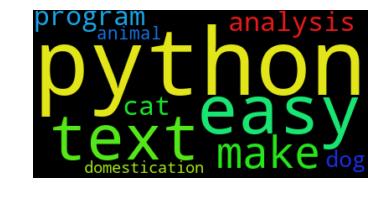

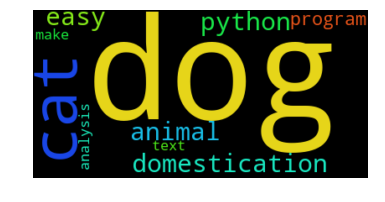

In [23]:
word_frequencies = {}

for topic in range(num_topics):
    feature_distribution = lda.components_[topic]
    word_frequencies = [ (vocabulary[idx], prob) for idx, prob in enumerate(feature_distribution) ]
    # Alternative in case of errors
    #for idx, prob in enumerate(feature_distribution):
    #    word_frequencies[vocabulary[idx]] = prob
    show_wordcloud(word_frequencies)

## Application use case: news article headlines

In this example, we apply LDA over a list of 12,394 news article headlines from TechCrunch (https://techcrunch.com/). This dataset is publicly available on Kaggle (https://www.kaggle.com/), see the full link here:
- https://www.kaggle.com/PromptCloudHQ/titles-by-techcrunch-and-venturebeat-in-2017

### Load news article headlines from CSV file

`pandas` is a very popular package for handling structured files like CSV files.

In [1]:
import pandas as pd
df = pd.read_csv('data/news-articles/news-article-headlines-techcrunch.csv', encoding = "ISO-8859-1")

# Remove rows where Title is "NaN" to avoid any errors later on
df = df[pd.notnull(df['title'])]

# Extract list of headline from data frame
news_headlines = df['title'].tolist()

# Print the first 5 headlines
for idx in range(5):
    print (news_headlines[idx])

Gaming firm Razer seeks to raise over $600M in Hong Kong IPO
Mendel.ai nabs $2 million to match cancer patients with the latest clinical trials
These cities in Californias East Bay are raking in venture capital
A walk around Station F with Emmanuel Macron
Crunch Report | Facebook Helps You Find Wi-Fi


### Preprocess all news article headlines

Store process headlines in a new list to avoid overwriting the orginals.

In [25]:
processed_news_headlines = [''] * len(news_headlines)

for idx, doc in enumerate(news_headlines):
    processed_news_headlines[idx] = preprocess_text(doc)
    #processed_news_headlines[idx] = preprocess_text(doc, stemmer=porter_stemmer)
    #processed_news_headlines[idx] = preprocess_text(doc, lemmatizer=wordnet_lemmatizer)


### Generate document term matrix

In [26]:
num_words = 1000 # Top 1000 words

tf_vectorizer_news_headlines = CountVectorizer(max_df=0.95, min_df=1, max_features=num_words, stop_words='english')

tf_news_headlines = tf_vectorizer_news_headlines.fit_transform(processed_news_headlines)

vocabulary_news_headlines = tf_vectorizer_news_headlines.get_feature_names()

### Perform LDA

Since these are 12k+ documents, setting the number of topics to 2 is usually not very meaningful. There are not straightforwards rules how to set this number. A common value to start with is 20, inspect the results, and potentially repeat this step with different values.

**Note:** This will take now several seconds or even minutes, but still managable. If you have (really) large data, it it is recommended to apply LDA first on a sample to see if all works (no errors) and if the results "look" meaningful.

In [27]:
num_topics = 20
lda_news_headlines = LatentDirichletAllocation(n_topics=num_topics, max_iter=100, learning_method='online', learning_offset=50.,random_state=0)
lda_news_headlines.fit(tf_news_headlines)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_jobs=1, n_topics=20, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

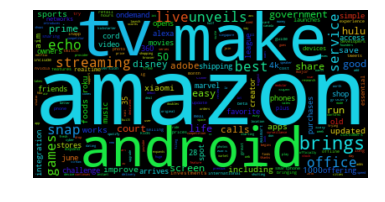

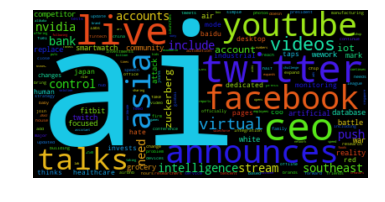

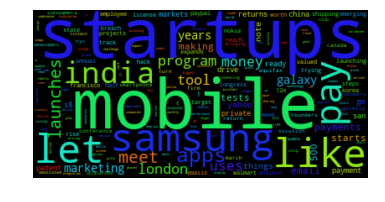

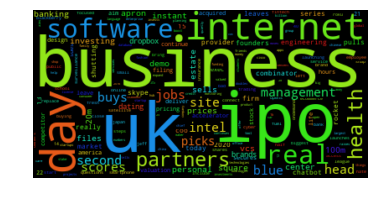

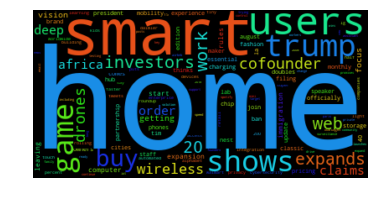

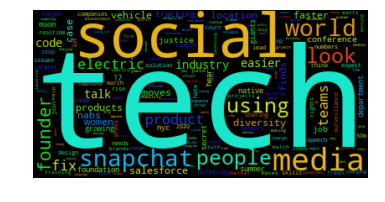

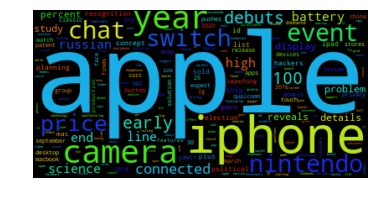

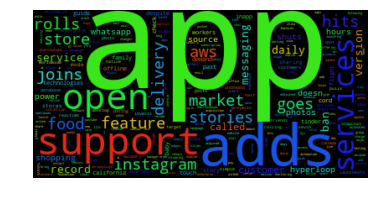

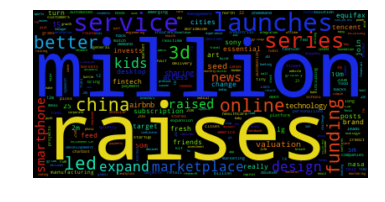

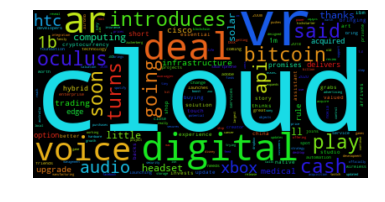

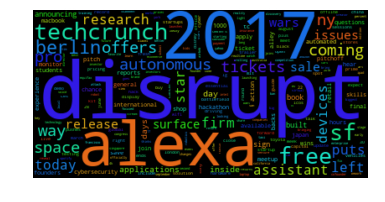

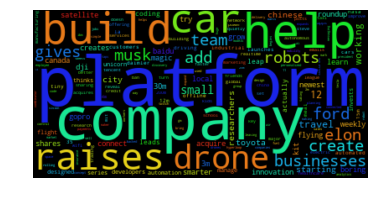

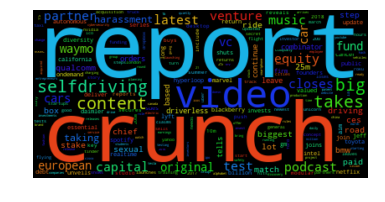

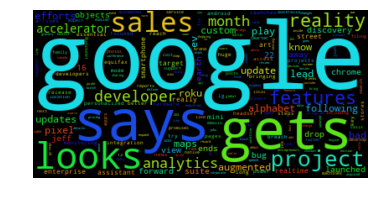

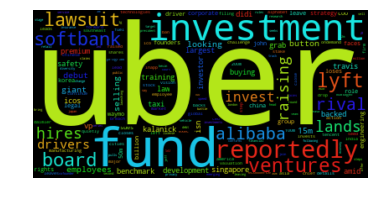

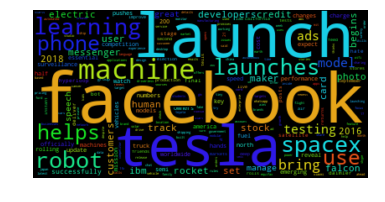

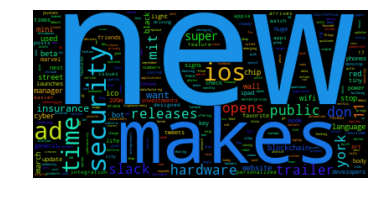

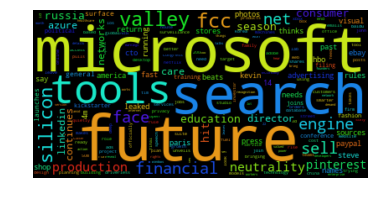

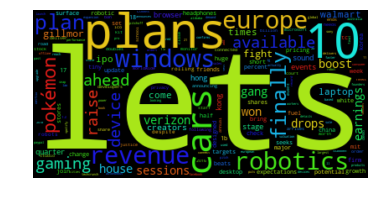

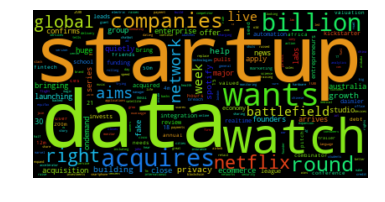

In [29]:
word_frequencies = {}

for topic in range(num_topics):
    feature_distribution = lda_news_headlines.components_[topic]
    word_frequencies = [ (vocabulary_news_headlines[idx], prob) for idx, prob in enumerate(feature_distribution) ]
    # Alternative in case of errors
    #for idx, prob in enumerate(feature_distribution):
    #    word_frequencies[vocabulary[idx]] = prob
    show_wordcloud(word_frequencies, max_words=25)

In [67]:
doc_topic_headlines = lda_news_headlines.transform(tf_news_headlines)

In [68]:
display_documents(doc_topic_headlines, max_documents=25)

doc: 0   topic: 18
doc: 1   topic: 12
doc: 2   topic: 12
doc: 3   topic: 0
doc: 4   topic: 12
doc: 5   topic: 2
doc: 6   topic: 4
doc: 7   topic: 3
doc: 8   topic: 5
doc: 9   topic: 13
doc: 10   topic: 12
doc: 11   topic: 8
doc: 12   topic: 1
doc: 13   topic: 6
doc: 14   topic: 8
doc: 15   topic: 13
doc: 16   topic: 3
doc: 17   topic: 10
doc: 18   topic: 10
doc: 19   topic: 15
doc: 20   topic: 18
doc: 21   topic: 8
doc: 22   topic: 1
doc: 23   topic: 14
doc: 24   topic: 15
